## Import Modules

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## Load Clean DataFrame

In [2]:
with open('./Data/clean_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df['X'] = df['selftext'] + " " + df['title']

## Import Stopword List

In [4]:
with open('./Data/stop_word_list.pkl', 'rb') as f:
    stop_word_list = pickle.load(f)

## CountVectorize Subreddit Lists and Find Top Words

In Scikit-Learn

The CountVectorizer transformer from the sklearn.feature_extraction model has its own internal tokenization and normalization methods. The fit method of the vectorizer expects an iterable or list of strings or file objects, and creates a dictionary of the vocabulary on the corpus. When transform is called, each individual document is transformed into a sparse array whose index tuple is the row (the document ID) and the token ID from the dictionary, and whose value is the count:

In [5]:
cc_text = list(df[df.subreddit=='cordcutters'].title + ' ' + df[df.subreddit=='cordcutters'].selftext)
piracy_text = list(df[df.subreddit=='Piracy'].title + ' ' + df[df.subreddit=='Piracy'].selftext)

In [6]:
len(cc_text), len(piracy_text)

(933, 636)

In [7]:
cvec = CountVectorizer(stop_words=stop_word_list)
cvec_cc = cvec.fit_transform(cc_text)
cc_df_vec = pd.SparseDataFrame(cvec_cc, 
                               columns = cvec.get_feature_names(), 
                               default_fill_value=0)

cc_words_df = pd.DataFrame(cc_df_vec.sum(),
                            columns = ['count']).sort_values('count', ascending=False)

cc_words_df.head(20)

,count
tv,774
antenna,344
just,309
channels,301
streaming,296
cable,277
internet,266
live,231
like,221
service,205


In [8]:
cvec = CountVectorizer(stop_words='english')
cvec_piracy = cvec.fit_transform(piracy_text)
piracy_df_vec = pd.SparseDataFrame(cvec_piracy, 
                               columns = cvec.get_feature_names(), 
                               default_fill_value=0)

piracy_words_df = pd.DataFrame(piracy_df_vec.sum(),
                            columns = ['count']).sort_values('count', ascending=False)

piracy_words_df.head(20)

,count
im,168
download,151
know,147
like,144
just,143
use,115
dont,106
ampxb,104
ive,104
torrent,100


#### Plot the Top 20 Words in both Subreddits

In [9]:
cc_words_df['count'][:20]

tv           774
antenna      344
just         309
channels     301
streaming    296
cable        277
internet     266
live         231
like         221
service      205
watch        195
use          169
want         166
new          164
sports       159
channel      157
need         147
ive          144
cord         141
month        140
Name: count, dtype: int64

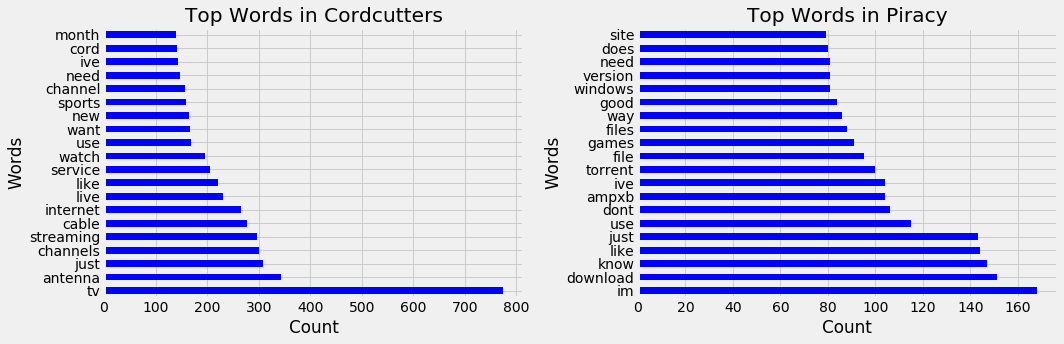

In [10]:
figure, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax[0].set_xlabel('Count')
ax[1].set_xlabel('Count')
ax[0].set_ylabel('Words')
ax[1].set_ylabel('Words')

cc_words_df['count'][:20].plot(ax = ax[0], title = 'Top Words in Cordcutters', kind='barh', color='blue')
piracy_words_df['count'][:20].plot(ax = ax[1], title = 'Top Words in Piracy', kind='barh', color='blue')

figure.tight_layout();

In [11]:
# cc_words_df['count'][:20].plot(kind='bar', color='blue', figsize=(20,10),
#                                    fontsize=25, rot=45)

# plt.xlabel('Words', fontsize=25)
# plt.ylabel('Count', fontsize=25)
# plt.title(fontsize = 25, s='Top Words in Cordcutters')
# figure.tight_layout();

#### Plot the Top 20 Overlapping Words

In [12]:
df_overlap_w_nulls = cc_words_df.join(piracy_words_df, rsuffix='_piracy')

In [13]:
df_overlap = df_overlap_w_nulls[(df_overlap_w_nulls['count']>0) &(df_overlap_w_nulls['count_piracy']>0)]

In [14]:
df_overlap.rename(columns = {'count': 'count_cordcutters'}, inplace=True)

In [15]:
df_overlap_by_cordcutters = df_overlap.sort_values(by='count_cordcutters', ascending=False)[:20]
df_overlap_by_piracy = df_overlap.sort_values(by='count_piracy', ascending=False)[:20]

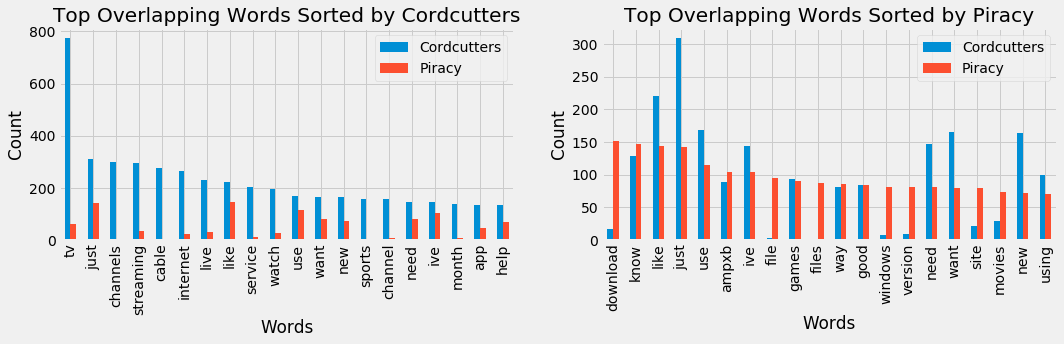

In [16]:
figure, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax[0].set_xlabel('Words')
ax[1].set_xlabel('Words')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')

df_overlap_by_cordcutters.plot(ax = ax[0], title = 'Top Overlapping Words Sorted by Cordcutters', kind='bar')
df_overlap_by_piracy.plot(ax = ax[1], title = 'Top Overlapping Words Sorted by Piracy', kind='bar')

ax[0].legend(labels=('Cordcutters', 'Piracy'))
ax[1].legend(labels=('Cordcutters', 'Piracy'))

figure.tight_layout();

In [17]:
# df_overlap_by_piracy.plot(kind='bar', figsize=(20,10),
#                               fontsize=25, rot=45)

# plt.xlabel('Words', fontsize=25)
# plt.ylabel('Count', fontsize=25)
# plt.title(fontsize = 25, s='Top Overlapping Words Sorted by Piracy')

# plt.legend(labels=('Cordcutters', 'Piracy'))

# figure.tight_layout();

## Conduct Hypothesis Test

$H_0$: The subreddits for cordcutters and piracy have the same mean frequency for word $x$.

$H_A$: The subreddits for cordcutters and piracy have a different mean frequency for word $x$.

#### Create a Dictionary with the Statistically Significant Overlapping Words

In [18]:
ttest_dict = {}
for word in list(df_overlap.index):
    ttest_dict[word] = ttest_ind(
        cc_df_vec[word],
        piracy_df_vec[word]
    )

In [19]:
ttest_keys = []
ttest_values = []

for k,v in ttest_dict.items():
    ttest_keys.append(k)
    ttest_values.append(v[1])

In [20]:
np.array(ttest_keys)[np.where(np.array(ttest_values) < (0.05))]

array(['internet', 'amazon', 'access', 'think', 'http', 'buy', 'content',
       'smart', 'hd', 'provider', 'connection', 'came', 'figure',
       'bundle', 'expensive', 'especially', 'needed', 'purchased', 'user',
       'leave', 'software', 'windows', 'accounts', 'cast', 'office',
       'fuck', 'appear', 'events', 'grab'], dtype='<U15')

#### CountVectorize a DataFrame with Both Subreddits

In [21]:
cvec_concat_transformer = CountVectorizer(stop_words=stop_word_list)
cvec_concat = cvec_concat_transformer.fit_transform(df['X'])
concat_df_vec = pd.DataFrame(cvec_concat.toarray(),
                               columns = cvec_concat_transformer.get_feature_names())

# concat_df_vec[:20]

Insert a target column into this vectorized dataframe.

In [22]:
concat_df_vec.insert(0, 'my_labels', df['label'])

Extract the top words in each class from this vectorized dataframe.

In [23]:
top_words_cordcutters = list(concat_df_vec.groupby('my_labels').
     mean().T.sort_values(1, ascending=False).head(100).index)

top_words_piracy = list(concat_df_vec.groupby('my_labels').
     mean().T.sort_values(0, ascending=False).head(100).index)

Define what constitutes an overlapping word for plotting

In [24]:
top_words_overlap = [i for i in top_words_cordcutters if i in top_words_piracy]

#### Plot the Distribution of the Highest Frequency Overlapping Words

In [25]:
def plot_cvec_dist(words, dataframe, target = 'my_labels', classes = [0,1]):
    nrows = len(words)//2 if not len(words)%2 else len(words)//2 + 1
    class_0 = dataframe[dataframe[target]==classes[0]]
    class_1 = dataframe[dataframe[target]==classes[1]]
    fig, ax = plt.subplots(ncols=2, nrows=nrows, figsize=(20, 10*nrows))
    ax = ax.ravel()
    
    for i, word in enumerate(words):
        counts_0 = class_0[word].value_counts().to_dict()
        counts_1 = class_1[word].value_counts().to_dict()
        mean_0 = class_0[word].mean()
        mean_1 = class_1[word].mean()
        ax[i].bar(counts_0.keys(), counts_0.values(), color='goldenrod', alpha=.3)
        ax[i].bar(counts_1.keys(), counts_1.values(), color='grey', alpha=.3)
        ymin, ymax = ax[i].get_ylim()
        ax[i].plot([mean_0]*2, [ymin, ymax], ':', color='goldenrod')
        ax[i].plot([mean_1]*2, [ymin, ymax], ':', color='grey')
        ax[i].set_title(f'{word} frequency counts\nmeans: {mean_0:0.03f} vs {mean_1:0.03f}')
        ax[i].legend(labels=('Piracy', 'Cordcutters'))
        ax[i].set_xlabel('Number of Times')
        ax[i].set_ylabel('Number of Documents')

The plots below show the distribution of the top overlapping words in terms of how frequently they occur and their mean in each class.

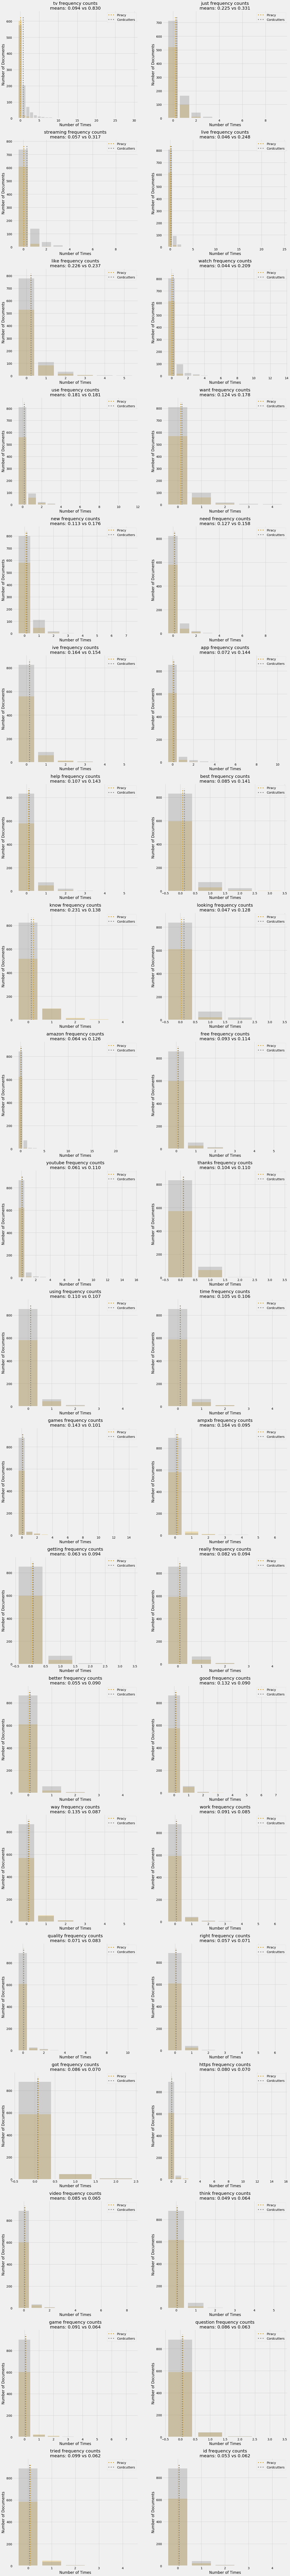

In [26]:
plot_cvec_dist(top_words_overlap, concat_df_vec)